# Figures and computational analyses for Jankowski et al.
This Notebook contains code to recreate analyses and figures from the manuscript:

**A fuzzy complex in the circadian clock turns an hourglass into a persistent oscillator** <br> Meaghan S. Jankowski, Daniel Griffith, Divya G. Shastry, Jacqueline F. Pelham, Garrett M. Ginell, Joshua Thomas, Pankaj Karande, Alex S. Holehouse, and Jennifer M. Hurley

### Dependencies
This notebook requires the following additional Python packages that can be installed using `pip` and/or `conda`.

* numpy (version 1.22.0 used, but this is not a hard requirement) Click here for installation info
* pandas (version 1.4.0 used, but this is not a hard requirement) Click here for installation info
* matplotlib (version 3.5.1 used but this is not a hard requirement) Click here for installation info
* seaborn (version 0.11.2 used but this is not a hard requirement) Click here for installation info
* scipy (version 1.7.3 used but this is not a hard requirement) Click here for installation info
* localcider (version 0.1.19 used but this is not a hard requirement) Click here for installation info
* protfasta (version 0.1.9 used but this is not a hard requirement) Click here for installation info
* metapredict (version 2.2 - this is a hard requirement - uses legacy version of 2.2) Click here for installation info

### Ortholog alignment
The set of aligned orthologs was generated using **Clustal Omega** version 1.2.3. For installation guidelines see here but this can also be done using the online Clustal Omega web server: https://www.ebi.ac.uk/Tools/msa/clustalo/.

### Conservation calculation
In addition, the amino acid conservation scores were calculated using the Python code developed by Capra and Singh. This code and all supporting data are provided freely here. In addition, a webserver is provided that enables the aligned set of orthologs provided in /data to be uploaded and the per-residue scores of the MSA to be calculated.

For our analysis we used the **property entropy** mode with a **window-size of 3 residues**, a gap cutoff of 0.99 (not available to select in the web server) and the BLOSUM62 matrices. The computed numbers referenced against the *N. crassa* sequence are provided in `data/` under `ortholog_conservation.csv`.

In [2]:
# Built-in packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib
import seaborn as sns
import random
from scipy.stats import gaussian_kde

# external packages
from localcider.sequenceParameters import SequenceParameters
import protfasta
import metapredict as meta

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# Set font to arial
font = {'family' : 'arial'}
matplotlib.rc('font', **font)

## FRQ sliding feature plots
* Supplemental Figs 1A
* Main text Figs 3A

In [2]:
# Import dataset
dataset = 'data/peptide_binding_data.csv'
df = pd.read_csv(dataset)

# Focus on 3-shift scanning peptides
shift3 = df[df['seq_type'] == '3-shift']

In [3]:
# Get N- and C-terminal residue number for each peptide
shift3.loc[:, 'NTD'] = shift3.loc[:, 'idx']*3 - 2
shift3.loc[:, 'CTD'] = shift3.loc[:, 'idx']*3 + 12
shift3.loc[318, 'CTD'] = 989 # Manually change last peptide since it's only 14aa

# Get average binding score of each peptide that overlaps every position
avg_binding = []
for i in range(1, 990):
    peptides = shift3[shift3['NTD'] <= i]
    peptides = peptides[peptides['CTD'] >= i]
    avg_binding.append(np.mean(peptides['avg']))

/Users/dan/miniconda3/envs/conda_env/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/dan/miniconda3/envs/conda_env/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [4]:
domain = np.arange(1, 990)
FRQ = 'MADSGDKSQGMRPPPFDSRGHPLPRRASPDKSITLENHRLARDTSSRVTSSSALGVTESQPQLKSSPTRRNSSGESEPTNWFNQSNRNPAAAFHDESHIMEVDPPFYQKETDSSNEESRYPPGRNPVHPPGGVQLPGFRPVAAHSSAADDYRSVIDDLTVENKRLKEELKRYKQFGSDVMRKEKLFEIKVHGLPRRKKRELEATLRDFAASLGDSSESTSQRRKTGRHGTAVHSSGVSLSKHDSSSSSRSRPVDSAYNSMSTGRSSHAPHSSGPSLGRPSLTRAKSVGTQKVENYLRDTPDGLLPHHIVMTDKEKKKLVVRRLEQLFTGKISGRNMQRNQSMPSMDAPLAPEGTNMAPPRPPPEGLREACIQLQDGDNPRKNRSSKDNGSASNSGGDQTELGGTGTGSGDGSGSGGRTGNNTSPPGAIAPDQRPTRPRDLDPDRVQIPSENMDYIRHLGLVSPEFLQGSRTSYQDVAPDAEGWVYLNLLCNLAQLHMVNVTPSFIRQAVSEKSTKFQLSADGRKIRWRGGTDGTKFSSDSSEDKSQQSPMTEDTEDGSDKNGRRKKRKTQQASSEIGRFGPSRSPSDTFHYKPMFVHRNSSSIETSLEESMSQGSEDAVDESNMGNSKWDFSGSGTTQQRRKRRYDGAIVYYTGAPFCTDLSGDPGDMSPTAQMTAGREVEGSGSGDEVEHVLQRTLSGSSLPIRPLSDDRARVAEVLDFDPGNPPELVADDGSSPNDEDFVFPWCEDPAKVRIQPIAKEVMEPSGLGGVLPDDHFVMLVTTRRVVRPILQRQLSRSTTSEDTAEFIAERLAAIRTSSPLPPRSHRLTVAPLQVEYVSGQFRRLNPAPLPPPAIFYPPFSTDSSWDDGDDLASDDEEVEEVEEDSYSEGQISRRANPHFSDNNTYMRKDDLAFDTETDVRMDSDDNRLSDSGHNMRAMMPRAEAVDGDDSPLAAVTGKEVDMLHTGSSVATAGGAESGYSSSMEDVSSS'

In [5]:
# KD hydropathy:
def sliding_window_KDhydropathy(seq, window_size):
    KD_SCALE = {'A':1.8, 'C':2.5, 'D':-3.5, 'E':-3.5, 'F':2.8, 
                'G':-0.4, 'H':-3.2, 'I':4.5, 'K':-3.9, 'L':3.8,
                'M':1.9, 'N':-3.5, 'P':-1.6, 'Q':-3.5, 'R':-4.5, 
                'S':-0.8, 'T':-0.7, 'V':4.2, 'W':-0.9, 'Y':-1.3}

    seq_hp = []
    for aa in seq:
        seq_hp.append(KD_SCALE[aa])
    seq_hp = np.array(seq_hp)

    windows = []
    sides = int((window_size-1)/2)
    for i in range(len(seq)):
        if i < sides:
            window = seq_hp[0:(i+sides+1)]
        elif i >= len(seq) - sides:
            window = seq_hp[(i-sides):]
        else:
            window = seq_hp[(i-sides):(i+sides+1)]
        windows.append(np.sum(window)/window_size)
    return np.array(windows)

In [6]:
# Conservation
# TODO copy method over from housetools
from housetools.sequence_tools import sequence_conservation

wt_id = 'sp|P19970|FRQ_NEUCR Frequency clock protein OS=Neurospora crassa (strain ATCC 24698 / 74-OR23-1A / CBS 708.71 / DSM 1257 / FGSC 987) OX=367110 GN=f'
al = protfasta.read_fasta('data/aligned_orthologs.fasta', alignment=True)

C = sequence_conservation.ConservationCalculator()
b = C.calculate_conservation(al, target=wt_id, mode='property entropy', gap_cutoff=0.99)



In [9]:
# Disorder (metapredict)

# Direct disorder
disorder = meta.predict_disorder(FRQ, legacy=True)     # NOTE: this figure is using v1 metapredict
smooth_disorder = np.convolve(disorder, [0.2]*5, 'same')

# Fix boundaries
smooth_disorder[:2] = disorder[:2]
smooth_disorder[-2:] = disorder[-2:]

/Users/dan/miniconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/dan/miniconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


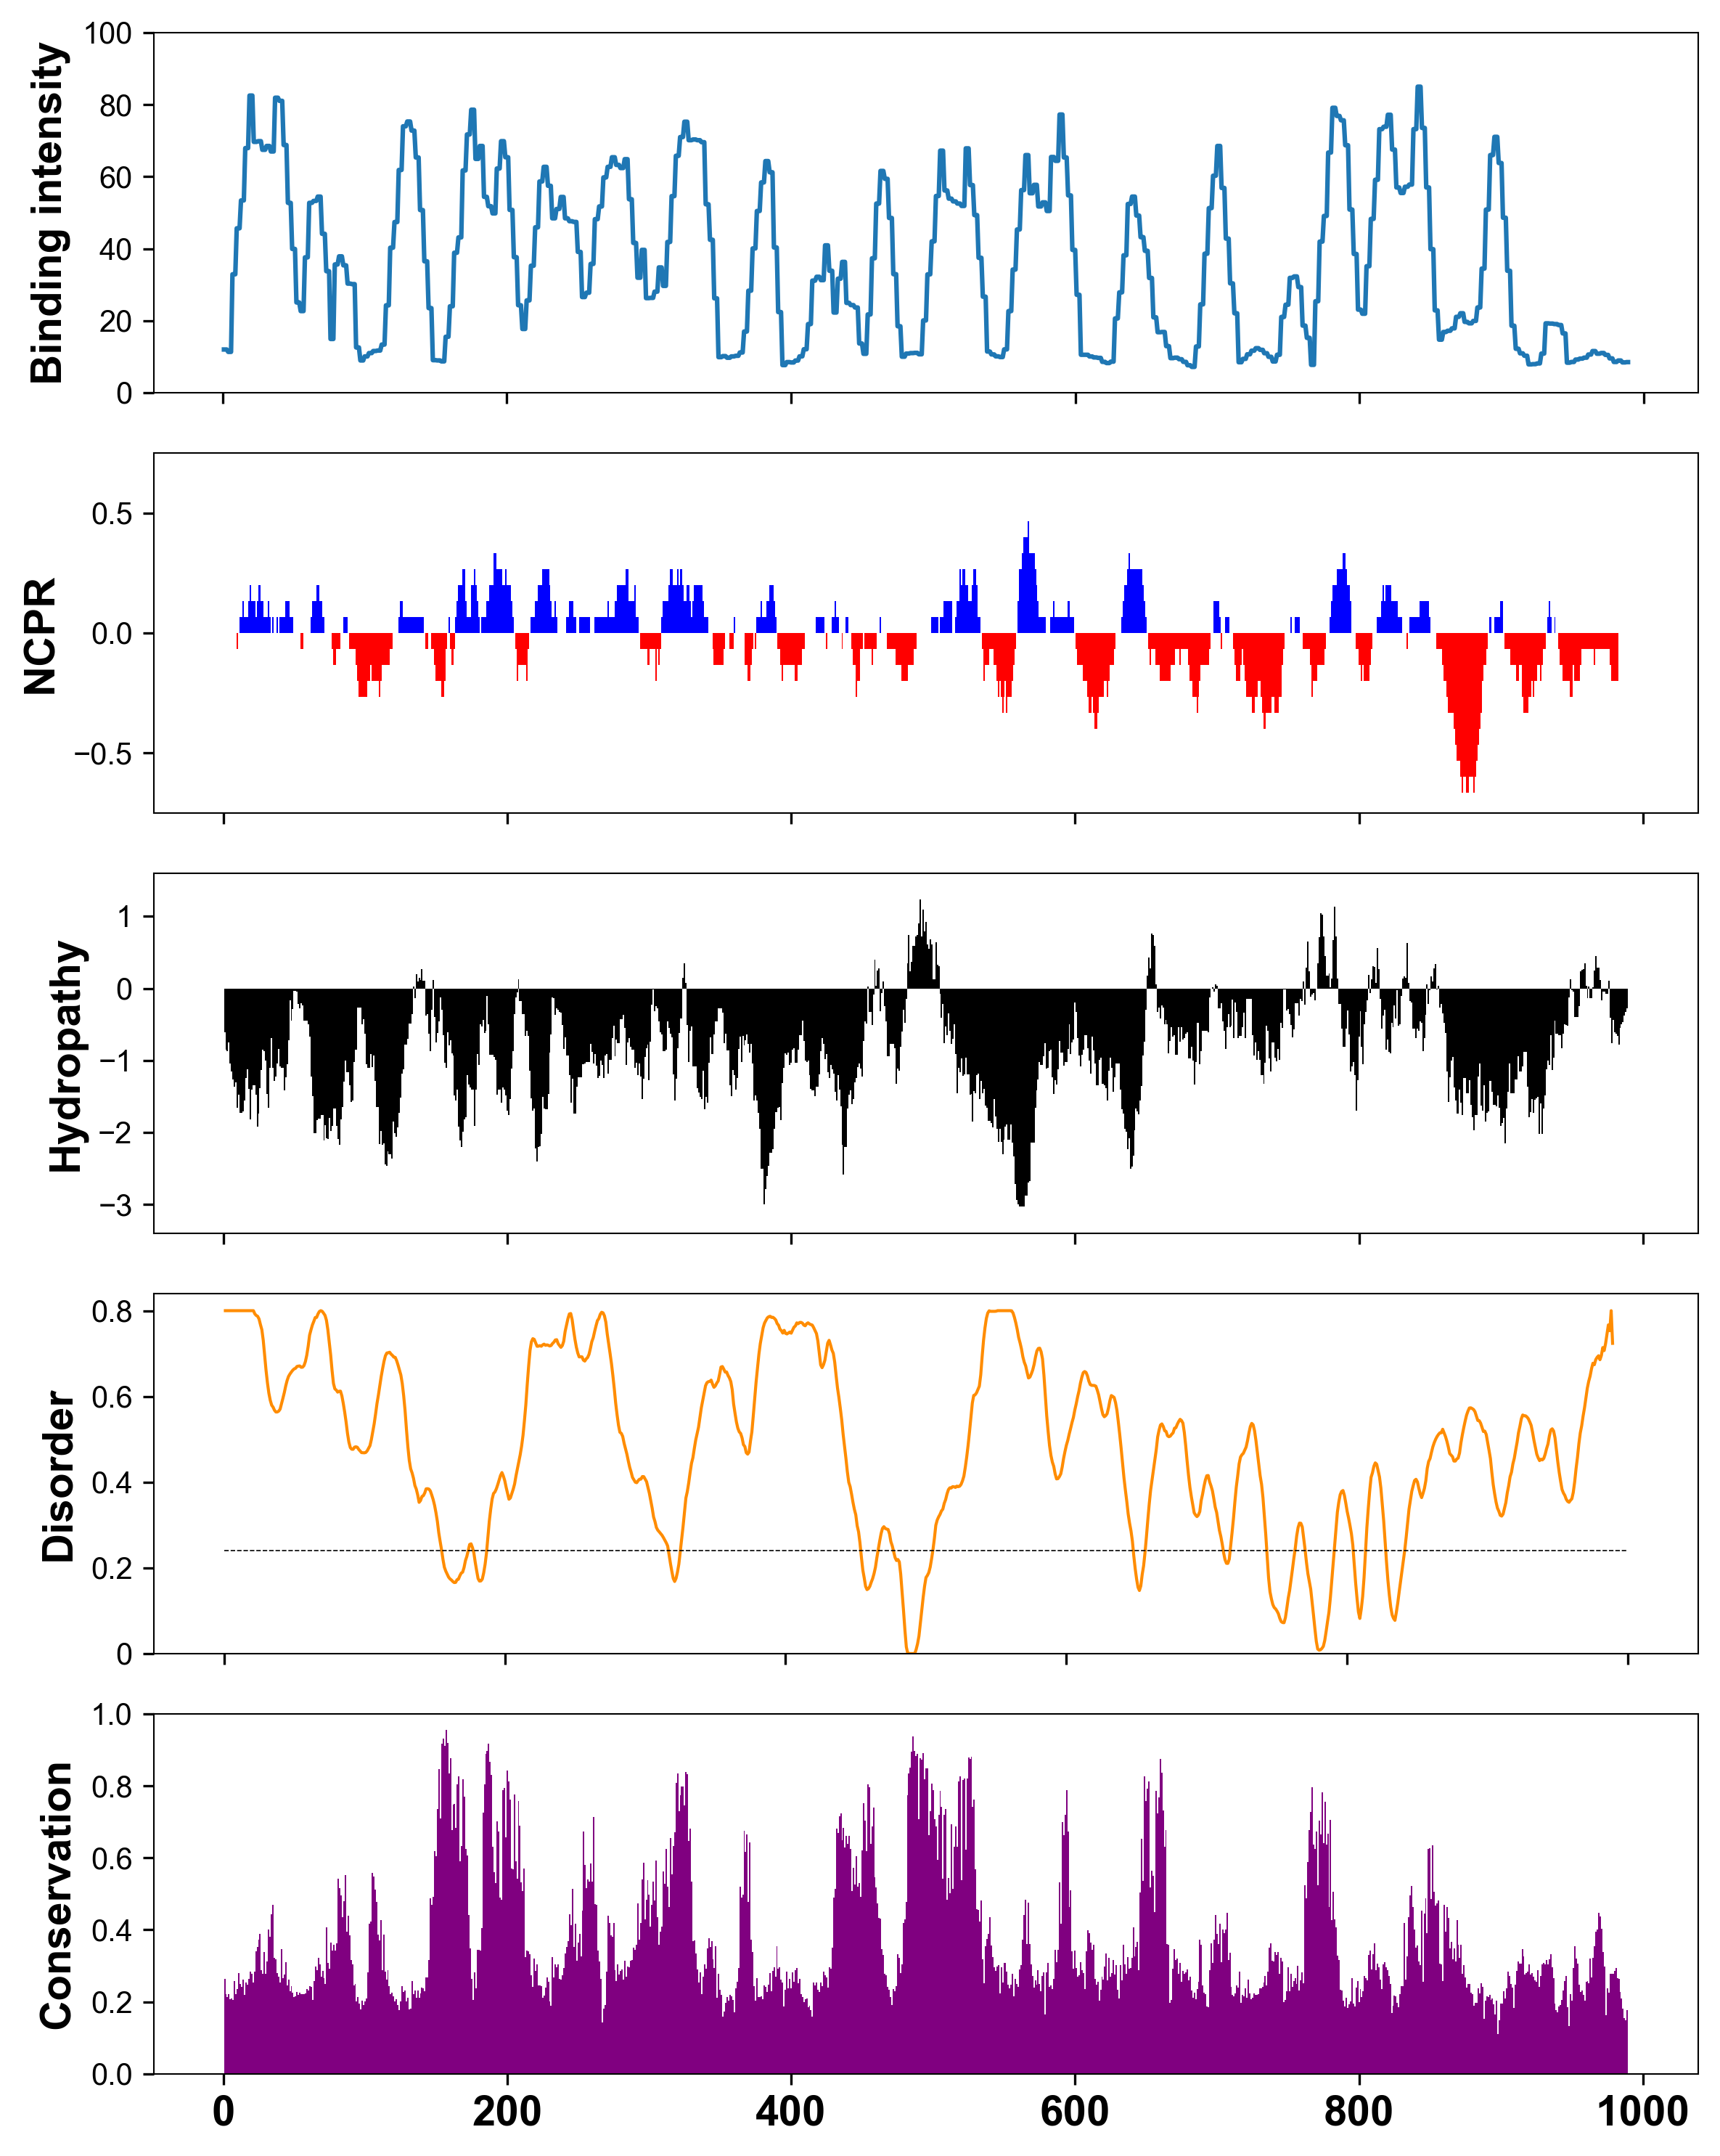

In [10]:
# Plot
fig, axs = plt.subplots(5,1, figsize=(8, 10), dpi=300)
ax1, ax2, ax3, ax4, ax5 = axs

# Avg binding over sequence
ax1.plot(domain, avg_binding)
ax1.set_ylabel('Binding intensity', fontweight='bold', fontsize=14)
ax1.set_ylim([0, 100])
ax1.set_xticklabels([])

# NCPR sliding window (window length=15)
seqOb = SequenceParameters(FRQ)
linNCPR = seqOb.get_linear_NCPR(blobLen=15)

positive_data = [x if x > 0 else 0 for x in linNCPR[1]]
negative_data = [x if x < 0 else 0 for x in linNCPR[1]]

ax2.bar(domain, negative_data, width=1, color='r')
ax2.bar(domain, positive_data, width=1, color='b')
ax2.set_ylim([-0.75, 0.75])
ax2.set_ylabel('NCPR', fontweight='bold', fontsize=14)
ax2.set_xticklabels([])

# Kyte-Doolittle hydropathy
ax3.bar(domain, sliding_window_KDhydropathy(FRQ, 15),  width=1, color='k')
ax3.set_ylim([-3.4, 1.6])
ax3.set_ylabel('Hydropathy', fontweight='bold', fontsize=14)
ax3.set_xticklabels([])

# Disorder
ax4.plot(np.arange(1,len(b.target_sequence)+1), smooth_disorder, color='darkorange', linewidth=1)
ax4.plot([0, 1000], [0.3]*2, 'k--', linewidth=0.4)
ax4.set_ylim([0, 1.05])
ax4.set_ylabel('Disorder', fontweight='bold', fontsize=14)
ax4.set_xticklabels([])
ax4.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])

# Conservation
ax5.bar(np.arange(1,len(b.target_sequence)+1), b.target_normalized_scores, color='purple',width=1)
ax5.set_ylim([0, 1])
ax5.set_ylabel('Conservation', fontweight='bold', fontsize=14)
ax5.set_xticklabels([0, 0, 200, 400, 600, 800, 1000], fontweight='bold', fontsize=14)

plt.tight_layout()
# plt.savefig('FigS1A_and_Fig3A')
plt.show()

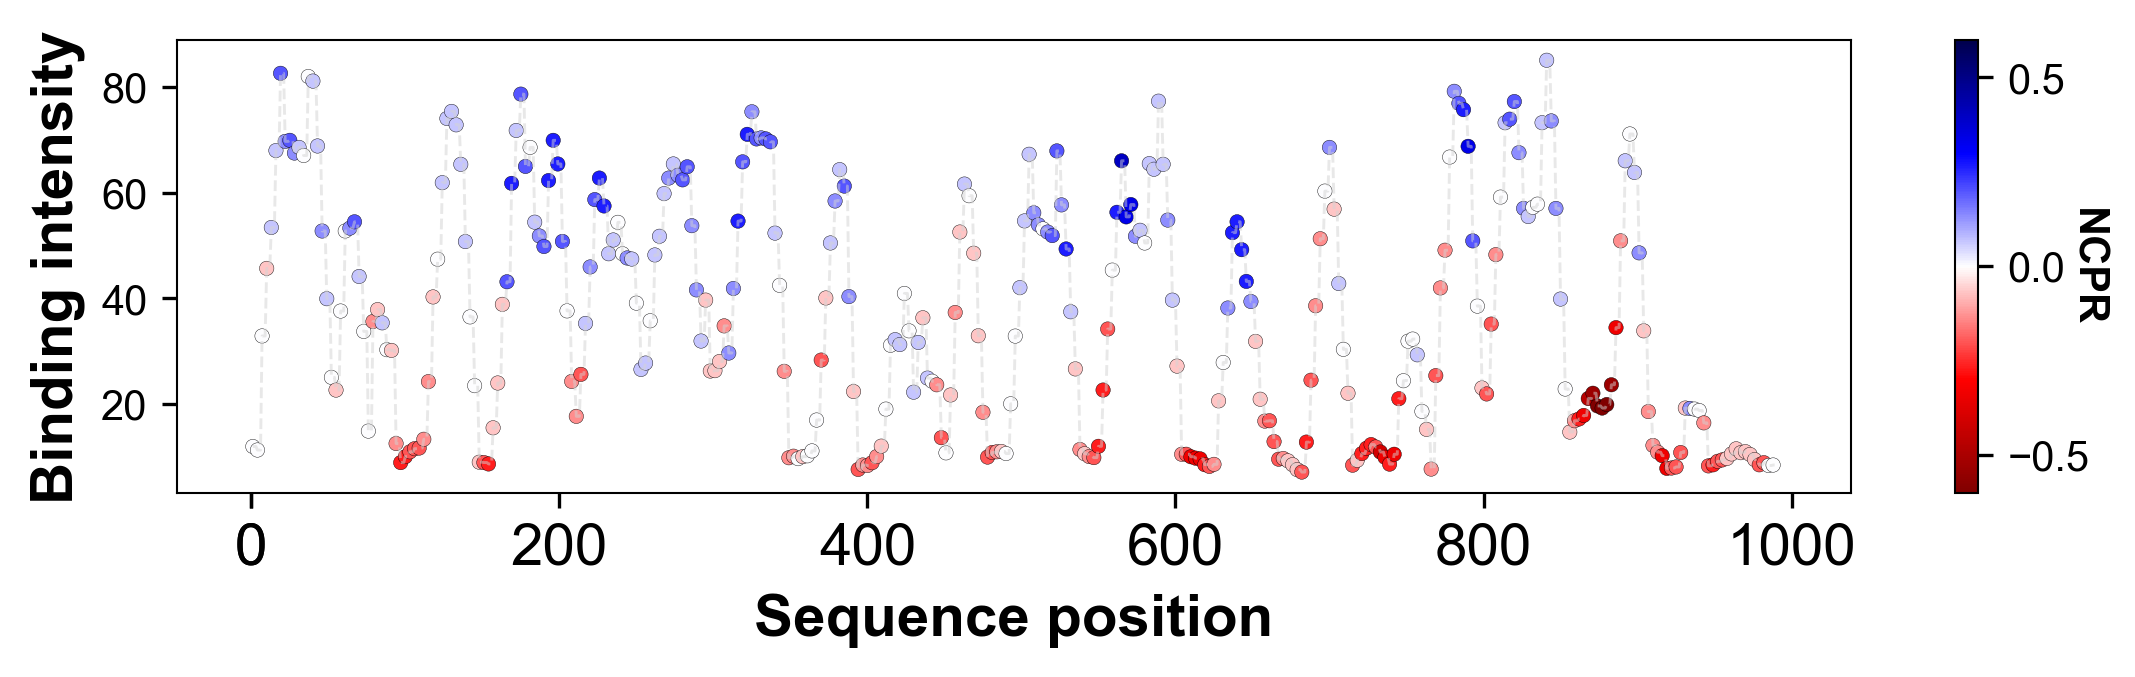

In [12]:
# Fig 3A: affinities combined with NCPR
plt.figure(figsize=(9, 2), dpi=300)
# Avg binding over sequence
plt.scatter(domain[0::3], avg_binding[0::3], c=linNCPR[1][0::3], s=12, cmap='seismic_r', edgecolor='k', linewidth=0.1, vmin=-0.6, vmax=0.6)
plt.plot(domain, avg_binding, color='lightgray', linestyle='--', linewidth=0.7, alpha=0.5)
plt.ylabel('Binding intensity', fontweight='bold', fontsize=14)
plt.xticks([0, 0, 200, 400, 600, 800, 1000], fontsize=14)
plt.xlabel('Sequence position', fontweight='bold', fontsize=14)
cbar = plt.colorbar()
cbar.set_ticks([-0.5,0,0.5])
cbar.set_label('NCPR', rotation=270, fontsize=10, fontweight='bold')
#plt.savefig('S3A_affinity_NCPR')
plt.show()

# Charge "blockiness" metric
*Derived from Lyons et al. 2023*
* Figure 3A
* Supplemental Figures S1A, S2E, S3A

In [11]:
def get_charge_blocks(idxs, blocksize=10):
    if blocksize % 2 == 0:
        lower = idxs-(blocksize//2)+1
        upper = idxs+(blocksize//2)
    else:
        lower = idxs-(blocksize//2)
        upper = idxs+(blocksize//2)

    i = 0
    blocks = []
    while i < len(lower):
        curr_lower_bound = lower[i]
        while i+1 < len(lower) and upper[i] >= lower[i+1]:
            i+=1
        blocks.append([int(curr_lower_bound), int(upper[i])])
        i+=1
    return blocks


def create_NCPR_island_plot(seq, ncpr_threshold, blocksize=10, histidine_charge=True, phos=False, plot=True, plot_out=None, title=''):
    """
    Create a sliding window NCPR plot with annotated charge blocks.

    Parameters
    ----------
    seq : str
        amino acid sequence of the protein
    ncpr_threshold : float
        ncpr threshold for annotating a charge block (absolute value)
    blocksize : int
        size of the sliding window to calculate NCPR
    histidine_charge : bool
        if True, His is treated as having a +1 charge, else it's assigned neutral charge
    phos : bool
        if True, Glu ('E') is considered to be a phosphorylation site with charge -1.5
    title : str
        title of the plot

    Returns
    -------
    (np.array, np.array)
        start and end locations of positive charge blocks and negative charge blocks respectively

    """
    
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(8, 2), dpi=300)
        plt.title(title)

    # NCPR sliding window (window length=15)
    domain = np.arange(1, len(seq)+1)
    seqOb = SequenceParameters(seq)
    linNCPR = seqOb.get_linear_sequence_composition(grps=[['K', 'R'], ['D'], ['E'], ['H']], blobLen=blocksize)
    if phos:
        neg_NCPR = linNCPR[1][1] + 1.5*linNCPR[1][2]
    else:
        neg_NCPR = linNCPR[1][1] + linNCPR[1][2]
        
    if histidine_charge:
        pos_NCPR = linNCPR[1][0] + linNCPR[1][3]
    else:
        pos_NCPR = linNCPR[1][0]
    
    linNCPR = (linNCPR[0], pos_NCPR - neg_NCPR)
    
    positive_data = [x if x > 0 else 0 for x in linNCPR[1]]
    negative_data = [x if x < 0 else 0 for x in linNCPR[1]]

    if plot:
        ax.bar(domain, negative_data, width=1, color='r')
        ax.bar(domain, positive_data, width=1, color='b')
        ax.set_ylim([-1.1, 1.1])
        ax.set_ylabel('NCPR', fontweight='bold', fontsize=14)
        ax.set_xticks([ 0, 200, 400, 600, 800, 1000])
        ax.set_xticklabels([0, 200, 400, 600, 800, 1000], fontweight='bold', fontsize=14)

    positive_islands = linNCPR[0][linNCPR[1] >= ncpr_threshold]
    negative_islands = linNCPR[0][linNCPR[1] <= -ncpr_threshold]
    
    pos_blocks = np.array(get_charge_blocks(positive_islands))
    neg_blocks = np.array(get_charge_blocks(negative_islands))
    
    if len(pos_blocks) > 0 and plot:
        ax.hlines([1]*len(pos_blocks.T[0]), pos_blocks.T[0], pos_blocks.T[1], color='blue', linewidth=2)
    if len(neg_blocks) > 0 and plot:
        ax.hlines([-1]*len(neg_blocks.T[0]), neg_blocks.T[0], neg_blocks.T[1], color='red', linewidth=2)

    if plot:
        plt.tight_layout()
        
        if plot_out != None:
            plt.savefig(plot_out)
        
        plt.show()
    
    return pos_blocks, neg_blocks

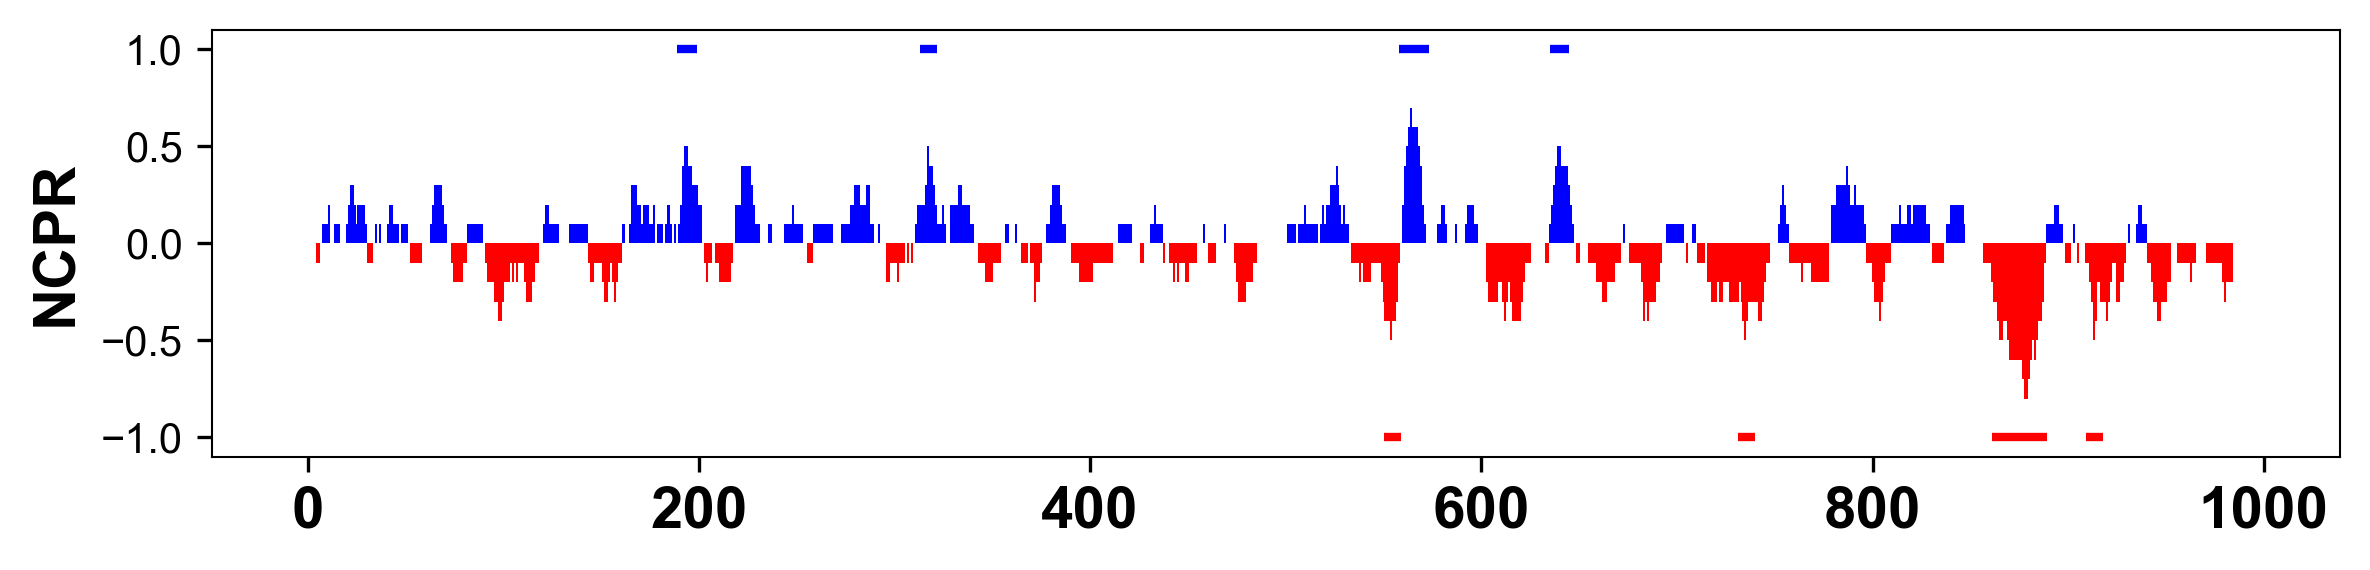

In [12]:
# WT FRQ charge blocks (Fig 3A)
frq_p, frq_n = create_NCPR_island_plot(FRQ, 0.5, blocksize=10, histidine_charge=False, plot=True)

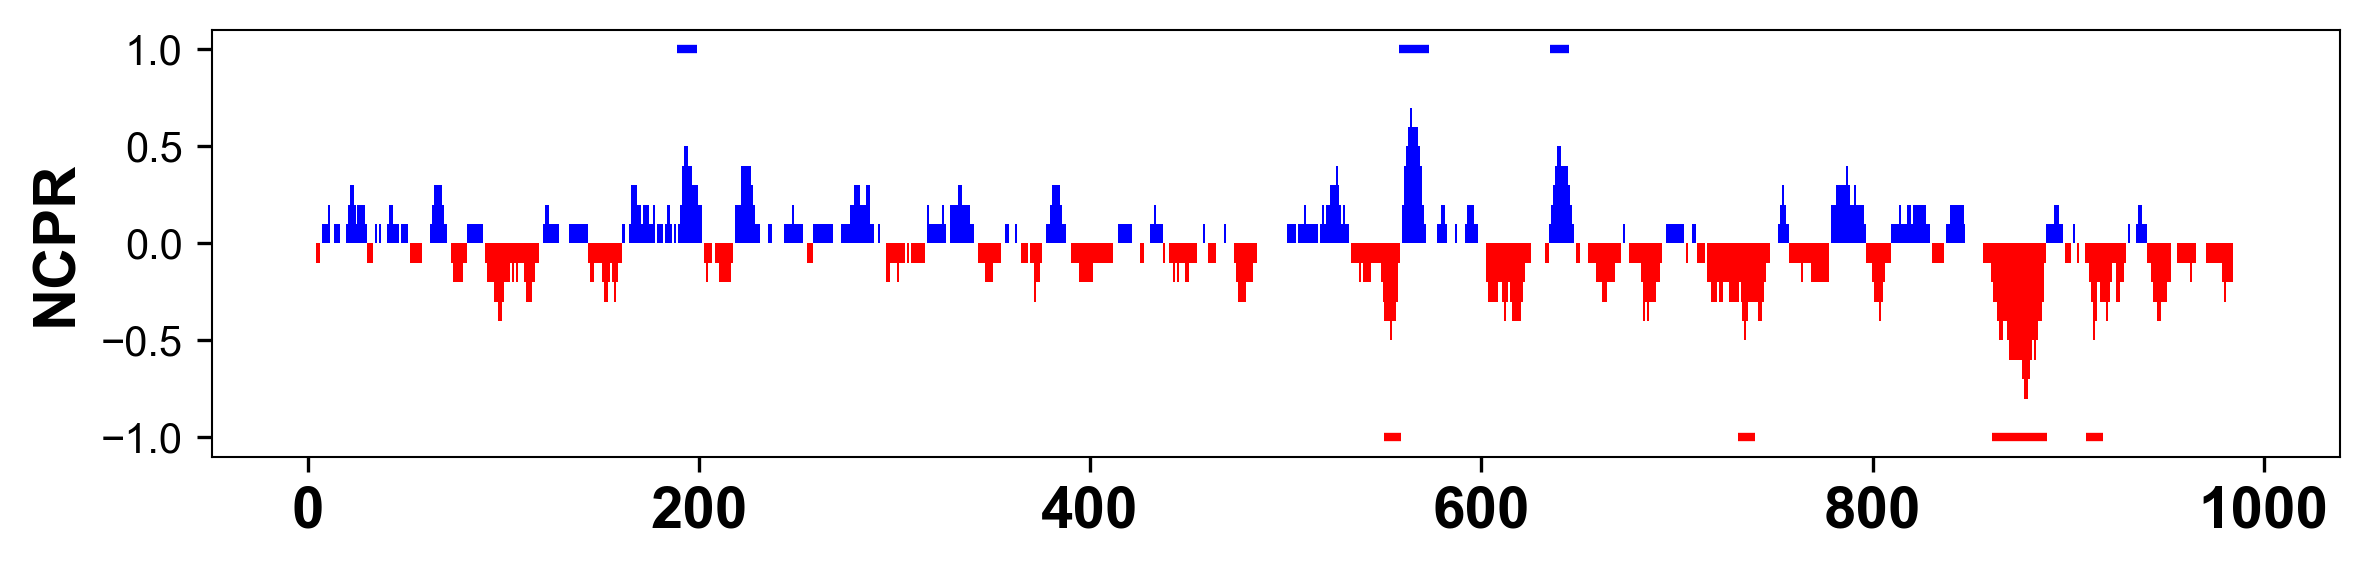

In [13]:
# FRQ KKK->AAA mutant charge blocks (Fig S3A)
frq_kkkmutant = FRQ[:314] + 'AAA' + FRQ[317:]
frq_p, frq_n = create_NCPR_island_plot(frq_kkkmutant, 0.5, blocksize=10, histidine_charge=False, plot=True)


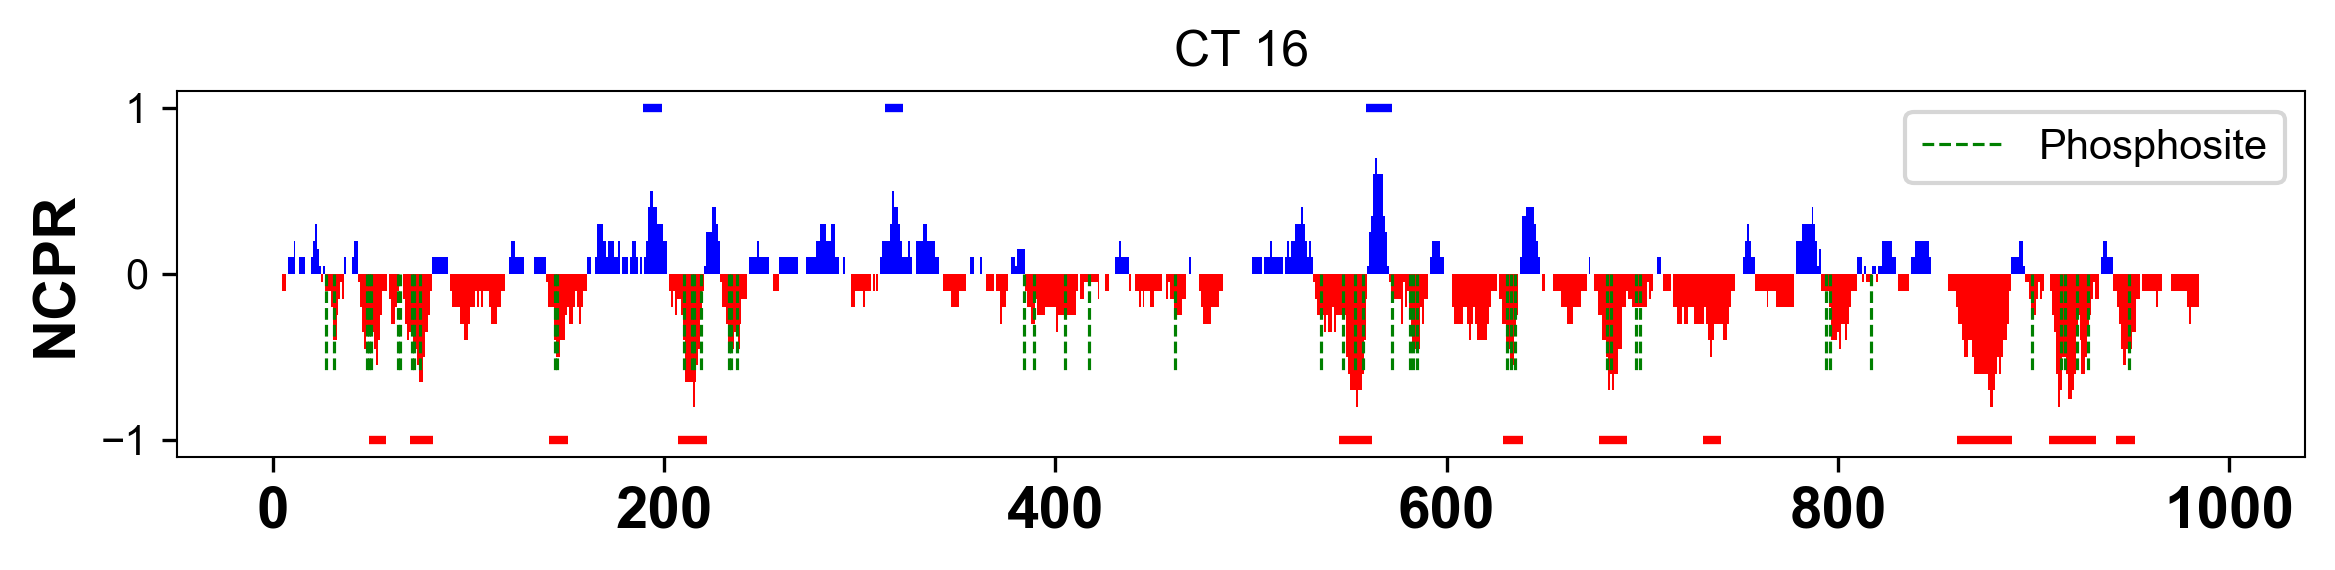

In [19]:
# Phosphorylation charge blocks (Fig S2E)

p16_FRQ = FRQ.replace('E', 'D')
p_file = 'data/P_CT16_FRQ.csv'
phos_df = pd.read_csv(p_file)

positions = phos_df.values[:, 0]-1
for index in positions:
    p16_FRQ = p16_FRQ[:index] + 'E' + p16_FRQ[index + 1:]

    
# Plot
fig, ax = plt.subplots(1,1, figsize=(8, 2), dpi=300)
plt.title('CT 16')

# NCPR sliding window (window length=15)
domain = np.arange(1, len(p16_FRQ)+1)
seqOb = SequenceParameters(p16_FRQ)
linNCPR = seqOb.get_linear_sequence_composition(grps=[['K', 'R'], ['D'], ['E'], ['H']], blobLen=10)

# If Phos=True
neg_NCPR = linNCPR[1][1] + 1.5*linNCPR[1][2]
phos_sites = np.where(np.array(list(p16_FRQ))=='E')[0]

# Uncharged histidine
pos_NCPR = linNCPR[1][0]

# Compute NCPR
linNCPR = (linNCPR[0], pos_NCPR - neg_NCPR)

positive_data = [x if x > 0 else 0 for x in linNCPR[1]]
negative_data = [x if x < 0 else 0 for x in linNCPR[1]]

ax.bar(domain, negative_data, width=1, color='r')
ax.bar(domain, positive_data, width=1, color='b')
ax.set_ylim([-1.1, 1.1])
ax.set_ylabel('NCPR', fontweight='bold', fontsize=14)
ax.set_xticks([ 0, 200, 400, 600, 800, 1000])
ax.set_xticklabels([0, 200, 400, 600, 800, 1000], fontweight='bold', fontsize=14)

# for ps in phos_sites:
ax.vlines(phos_sites, 0, -0.6, 'g', linestyle='--', linewidth=0.76, label='Phosphosite')

positive_islands = linNCPR[0][linNCPR[1] >= 0.5]
negative_islands = linNCPR[0][linNCPR[1] <= -0.5]

pos_blocks = np.array(get_charge_blocks(positive_islands))
neg_blocks = np.array(get_charge_blocks(negative_islands))

if len(pos_blocks) > 0:
    ax.hlines([1]*len(pos_blocks.T[0]), pos_blocks.T[0], pos_blocks.T[1], color='blue', linewidth=2)
if len(neg_blocks) > 0:
    ax.hlines([-1]*len(neg_blocks.T[0]), neg_blocks.T[0], neg_blocks.T[1], color='red', linewidth=2)

plt.legend()
plt.tight_layout()
plt.show()

## FRQ inverse-weighted distance (IWD) residue clustering
* Figure 3B
* Supplemental figures 2A-B

In [20]:
# Helper functions
def map_seq_mask(seq, res):
    """
    this function maps the sequence into a vector
    
    res as list of aa: e.g., ['F', 'Y', 'W']
    
    Input: string sequence 
    Output: a 1 or 0  vector as array matched to string legnth
    """
    mask_res = {}
    for aa in res:
        mask_res[aa] = 1
    
    mask = [0] * len(seq)
    
    # iterate sequence and edit mask
    for i,j in enumerate(seq):
        if j in mask_res:
            mask[i]= mask_res[j]

    return mask

# ------------------------------------------------------------------

def find_all_indicies(test_list, A):
    """
    A = list 
    B = value 
    Returns list of start positions where stringA is in stringB - including overlaps 
    """
    return [i for i, value in enumerate(test_list) if value == A]

# ------------------------------------------------------------------

def calc_average_inverse_distance(seq, res):
    """
    returns average IWD value
    """
    mask = map_seq_mask(seq, res)
    
    # dictionary of empty values for each index point
    all_hits = {i:0 for i in find_all_indicies(mask, 1)} 
    hits = np.array([i for i in all_hits.keys()])
    
    # iterate through index
    for i, p in enumerate(hits):
        resi_distances= 0
        # iterate through pairs for that index 
        for p1 in hits[np.arange(len(hits))!=i]:
            resi_distances += 1 / np.abs(p1-p)

        all_hits[p] = resi_distances
        #print(p,resi_distances)
    
    if len(hits) > 0:
        return sum(all_hits.values())/len(hits)
    else:
        return 0 

# ------------------------------------------------------------------

def shuffle_seq(s):
    """
    Returns a shuffled version of the sequence
    """
    return ''.join(random.sample(s,len(s)))

# ------------------------------------------------------------------
"""
Calculate IWD scores for different residue types
"""
def iwd_aliphatics(s):
    return calc_average_inverse_distance(s, ['M', 'I', 'L', 'V'])

def iwd_aromatics(s):
    return calc_average_inverse_distance(s, ['F', 'Y', 'W'])

def iwd_positives(s):
    return calc_average_inverse_distance(s, ['R', 'K', 'H'])

def iwd_negatives(s):
    return calc_average_inverse_distance(s, ['D', 'E'])

def calc_delta(s):
    return SequenceParameters(s).SeqObj.delta()

# ------------------------------------------------------------------

def calc_dist_and_zscore(seq, func, N=10000):
    """
    Computes some function over a protein sequence and returns a value. 
    Also computes the function for N shuffled variants, and calculates the Z-score of 
    the original sequence using the distribution of values for the random sequences.
    For robust analysis, use N>=10000.
    """
    # Calculate function for target sequence
    target_val = func(seq)
    
    # Get distribution of values for shuffled sequences
    vals = []
    for loop in range(N):
        random_seq = shuffle_seq(seq)       
        vals.append(func(random_seq))
    
    # Get z-score
    z_score = (target_val - np.mean(vals)) / np.std(vals)
        
    return (target_val, z_score, vals)


In [21]:
# Positive residue IWD clustering
#
FRQ_pcluster, pc_zscore, pc_dist = calc_dist_and_zscore(FRQ, iwd_positives, N=1000)

## NOTE: these function takes a while to run with large N (many randomized sequences). 
# Analysis in manuscript used N=10000. For demonstration purposes, this notebook uses N=1000
# Z-score and distribution will change slightly across runs due to stochasticity, especially with smaller N.

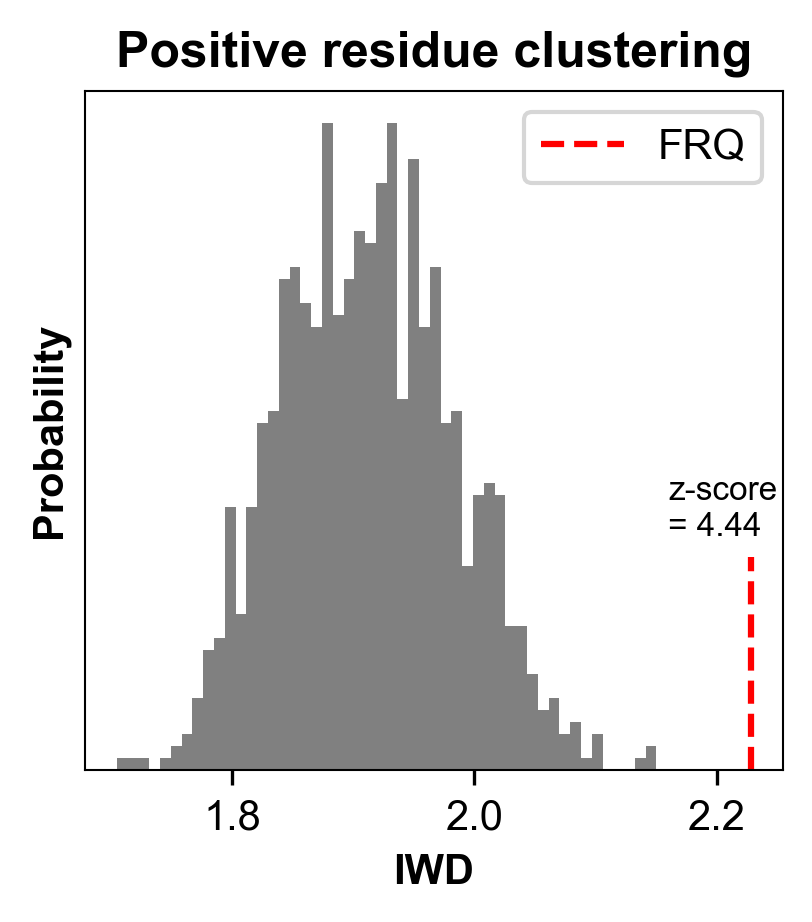

In [22]:
# Figure 3B
plt.figure(figsize=(3,3), dpi=300)
plt.hist(pc_dist, bins=50, density=True, color='gray')
plt.vlines(FRQ_pcluster, 0, 2, colors='r', linestyles='dashed', label='FRQ')
plt.title('Positive residue clustering', fontweight='bold')
plt.yticks([])
plt.ylabel('Probability', fontweight='bold')
plt.xlabel('IWD', fontweight='bold')
plt.text(2.16, 2.2, f'z-score\n= {round(pc_zscore, 2)}', fontsize=8)
plt.legend()

#plt.savefig('Fig3B')
plt.show()

In [23]:
# Negative residue IWD clustering
# Again, manuscript used N=10000, but for efficient demonstration using reduced N here
FRQ_ncluster, nc_zscore, nc_dist = calc_dist_and_zscore(FRQ, iwd_negatives, N=1000)

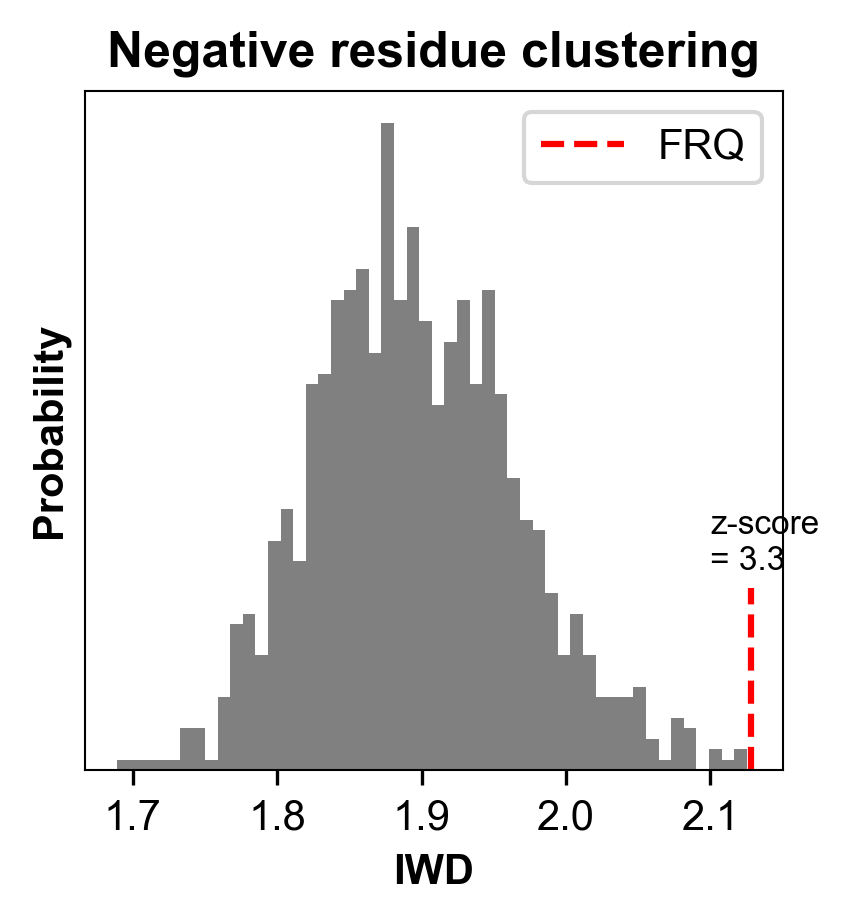

In [24]:
# Supplemental figure 2A
plt.figure(figsize=(3,3), dpi=300)
plt.hist(nc_dist, bins=50, density=True, color='gray')
plt.vlines(FRQ_ncluster, 0, 2, colors='r', linestyles='dashed', label='FRQ')
plt.xlabel('IWD', fontweight='bold')
plt.yticks([])
plt.ylabel('Probability', fontweight='bold')
plt.title('Negative residue clustering', fontweight='bold')
plt.text(2.1, 2.2, f'z-score\n= {round(nc_zscore, 2)}', fontsize=8)
plt.legend()

# plt.savefig('FigS2A')
plt.show()

In [25]:
# Aromatic residue IWD clustering
FRQ_aromcluster, aromc_zscore, aromc_dist = calc_dist_and_zscore(FRQ, iwd_aromatics, N=1000)

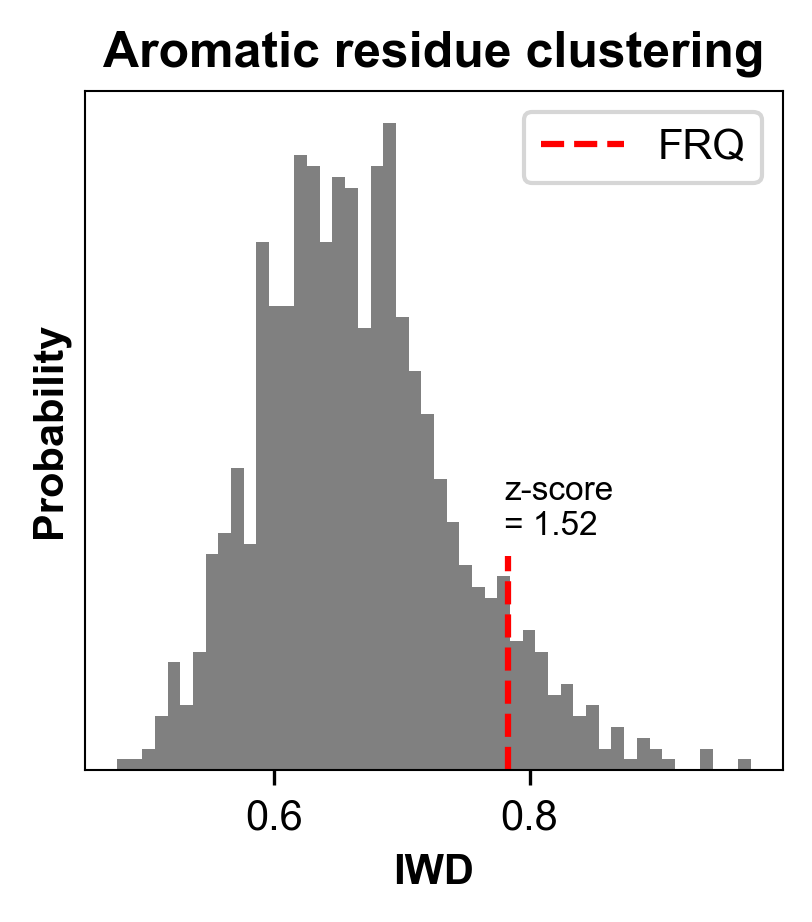

In [26]:
# Supplemental figure 2B
plt.figure(figsize=(3,3), dpi=300)
plt.hist(aromc_dist, bins=50, density=True, color='gray')
plt.vlines(FRQ_aromcluster, 0, 2, colors='r', linestyles='dashed', label='FRQ')
plt.xlabel('IWD', fontweight='bold')
plt.yticks([])
plt.ylabel('Probability', fontweight='bold')
plt.title('Aromatic residue clustering', fontweight='bold')
plt.text(0.78, 2.2, f'z-score\n= {round(aromc_zscore, 2)}', fontsize=8)
plt.legend()

# plt.savefig('FigS2B')
plt.show()

## Ortholog IWD comparisons
* Figure 3C
* Supplemental figure 2C

In [27]:
# Ortholog sequences and IWDs used in manuscript
per_ortholog_seqs = protfasta.read_fasta('data/per_orthologs.fasta')
fungal_ortholog_seqs = protfasta.read_fasta('data/fungal_orthologs.fasta')
per_ortholog_IWDs = pd.read_csv('data/per_orthologs_iwd_zscores.csv')
fungal_ortholog_IWDs = pd.read_csv('data/fungal_orthologs_iwd_delta_zscores.csv')

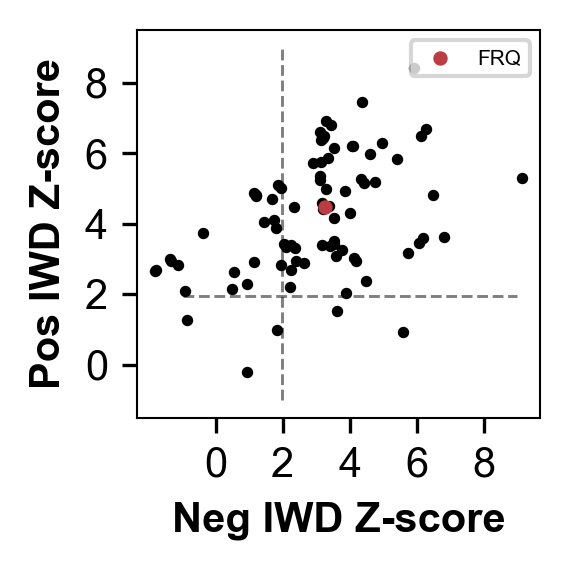

In [28]:
# Figure S2C: FRQ and fungal orthologs
x = fungal_ortholog_IWDs['neg_clust'].values
y = fungal_ortholog_IWDs['pos_clust'].values

plt.figure(figsize=(2,2), dpi=300)
plt.scatter(x[:-1], y[:-1], s=3, color='k')
plt.scatter(x[-1], y[-1], s=6, color='#BC3C41', label='FRQ')
plt.hlines(1.96, -1, 9, linestyle='--', color='k', linewidth=0.7, alpha=0.5)
plt.vlines(1.96, -1, 9, linestyle='--', color='k', linewidth=0.7, alpha=0.5)
plt.xlabel('Neg IWD Z-score', fontweight='bold')
plt.ylabel('Pos IWD Z-score', fontweight='bold')
plt.xticks([0,2,4,6,8])
plt.yticks([0,2,4,6,8])

plt.legend(loc='upper right', fontsize=5)
plt.tight_layout()

# plt.savefig('S3A')
plt.show()

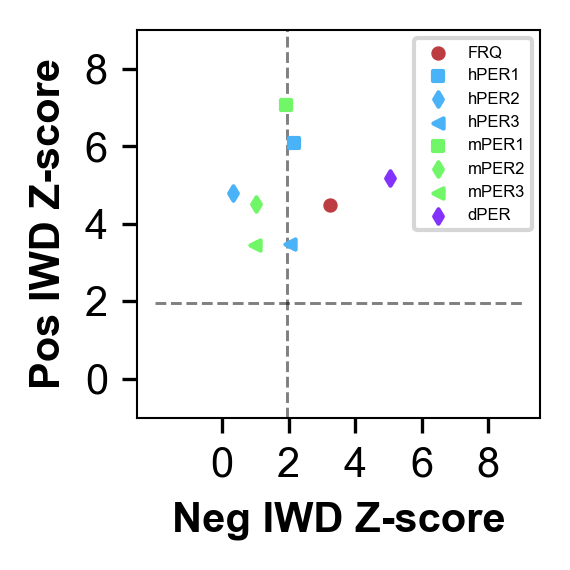

In [29]:
# Figure 3C: FRQ and PER orthologs
fig, ax = plt.subplots(1, 1, figsize=(2,2), dpi=300)

per_pos = per_ortholog_IWDs['pos_IWD'].values
per_neg = per_ortholog_IWDs['neg_IWD'].values
plt.scatter(x[-1], y[-1], s=6, color='#BC3C41', label='FRQ', zorder=3)
ax.scatter(per_neg[0], per_pos[0], marker='s', color='#4AB2F6', s=6, label='hPER1', zorder=3)
ax.scatter(per_neg[1], per_pos[1], marker='d', color='#4AB2F6', s=6, label='hPER2', zorder=3)
ax.scatter(per_neg[2], per_pos[2], marker='<', color='#4AB2F6', s=6, label='hPER3', zorder=3)
ax.scatter(per_neg[3], per_pos[3], marker='s', color='#70F667', s=6, label='mPER1', zorder=3)
ax.scatter(per_neg[4], per_pos[4], marker='d', color='#70F667', s=6, label='mPER2', zorder=3)
ax.scatter(per_neg[5], per_pos[5], marker='<', color='#70F667', s=6, label='mPER3', zorder=3)
ax.scatter(per_neg[6], per_pos[6], marker='d', color='#8331FC', s=6, label='dPER', zorder=3)

ax.set_ylim([-1,9])
ax.hlines(1.96, -2, 9, linestyle='--', color='k', linewidth=0.7, alpha=0.5, zorder=1)
ax.vlines(1.96, -1, 9, linestyle='--', color='k', linewidth=0.7, alpha=0.5, zorder=1)
ax.set_xlabel('Neg IWD Z-score', fontweight='bold')
ax.set_ylabel('Pos IWD Z-score', fontweight='bold')
ax.set_xticks([0,2,4,6,8])
ax.set_yticks([0,2,4,6,8])

plt.tight_layout()
ax.legend(fontsize=4)

# plt.savefig('Fig3C')
plt.show()

## N crassa IWD comparison
* Supplemental figure S2D

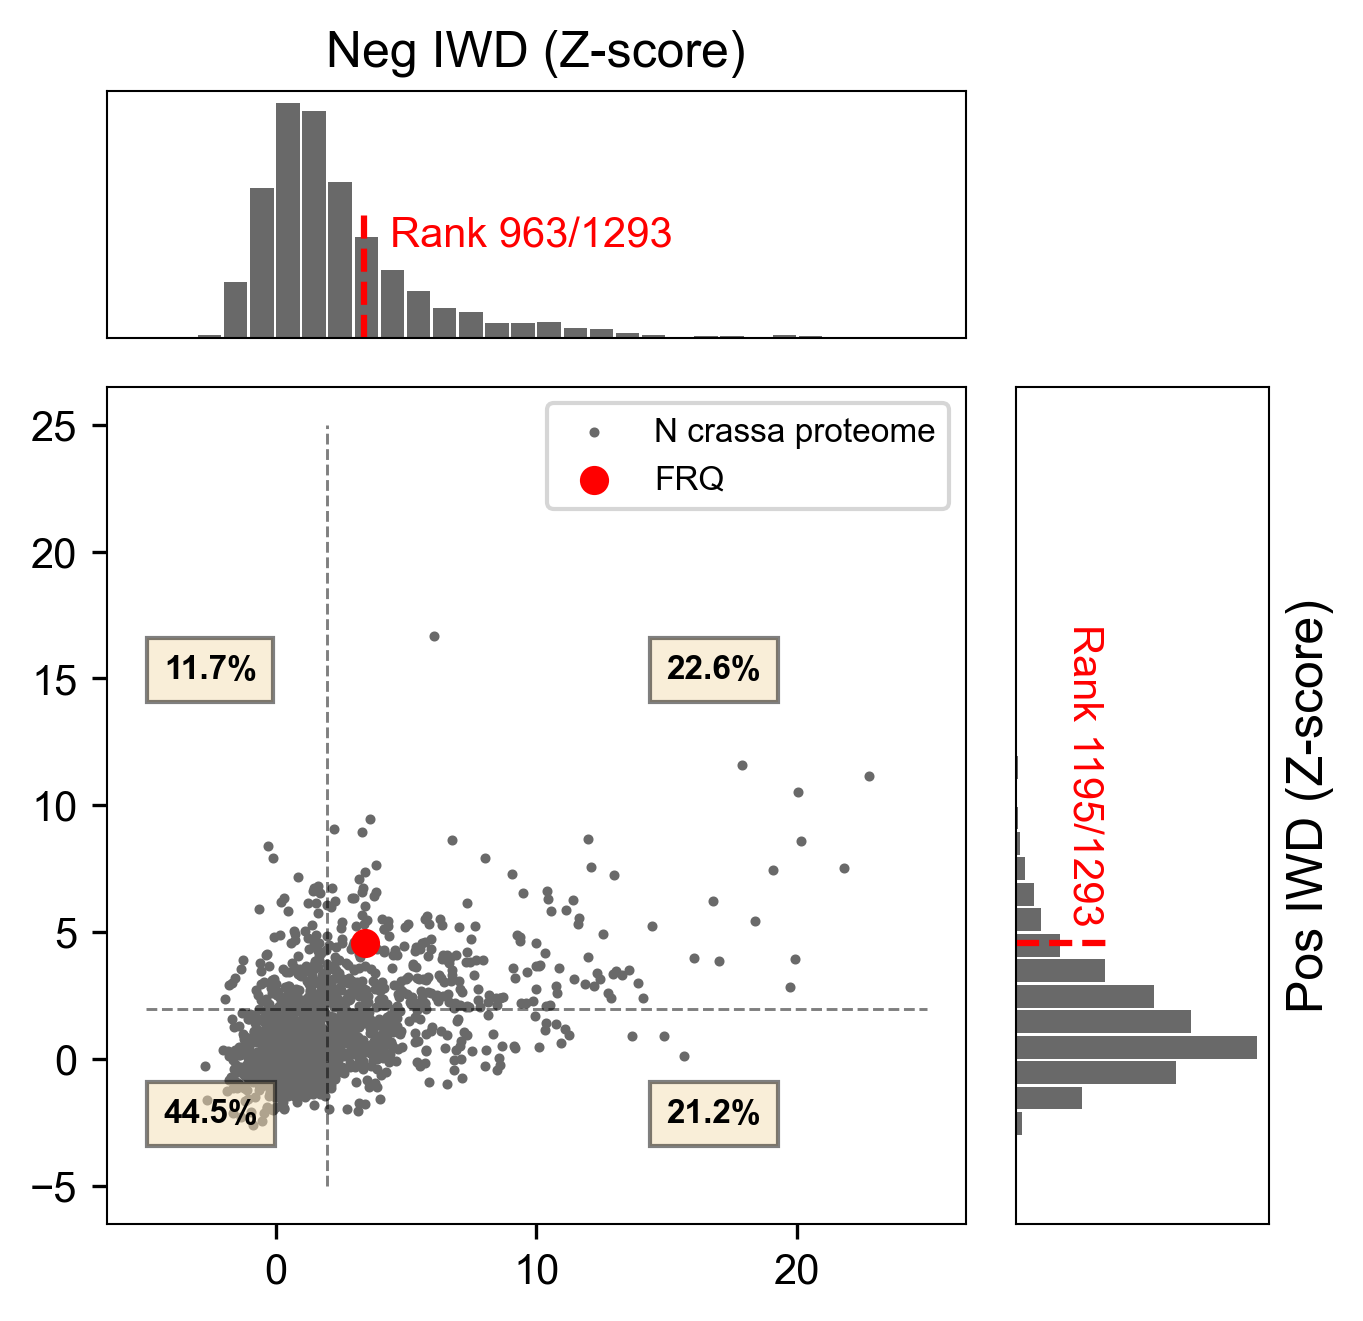

In [6]:
# Load ncrassa proteins from file
ncrassa_df = pd.read_csv('data/Ncrassa_IWD_zscores.csv', index_col=0, names=['pos', 'neg'])

# Calculate fraction of each "quadrant"
total = len(ncrassa_df)

sig_pos = ncrassa_df[ncrassa_df['pos'] > 1.96]
nonsig_pos = ncrassa_df[ncrassa_df['pos'] <= 1.96]
sig_neg = ncrassa_df[ncrassa_df['neg'] > 1.96]
sig_both = sig_pos[sig_pos['neg'] > 1.96]
nonsig_both = nonsig_pos[nonsig_pos['neg'] <= 1.96]

f_sig_both = len(sig_both) / total
f_sig_pos = (len(sig_pos) / total) - f_sig_both
f_sig_neg = (len(sig_neg) / total) - f_sig_both
f_nonsig = len(nonsig_both) / total

# Calculate FRQ's 'ranking'
FRQ_posIWD = 4.57
FRQ_negIWD = 3.41

sorted_pos = sorted(ncrassa_df['pos'].values)
sorted_neg = sorted(ncrassa_df['neg'].values)

frq_pos_rank = np.searchsorted(sorted_pos, FRQ_posIWD) + 1
frq_neg_rank = np.searchsorted(sorted_neg, FRQ_negIWD) + 1


# PLOT
fig = plt.figure(figsize=(5,5), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(4, 4)

ax1 = fig.add_subplot(gs[0, :-1])
ax1.set_title('Neg IWD (Z-score)', fontsize=12)
ax1.hist(ncrassa_df['neg'], range=[-5,25], bins=30, rwidth=0.9, color='dimgray')
ax1.set_xticks([])
ax1.set_yticks([])

ax1.vlines(FRQ_negIWD, 0, 140, linestyle='--', color='red')
ax1.text(FRQ_negIWD+1., 100, f'Rank {frq_neg_rank}/{total}', color='red')

##

ax2 = fig.add_subplot(gs[1:, -1])
ax2.set_ylabel('Pos IWD (Z-score)', fontsize=12)
ax2.yaxis.set_label_position("right")
ax2.hist(ncrassa_df['pos'], range=[-5,25], bins=30, color='dimgray', orientation='horizontal', rwidth=0.9)
ax2.set_xticks([])
ax2.set_yticks([])

ax2.hlines(FRQ_posIWD, 0, 120, linestyle='--', color='red')
ax2.text(64, FRQ_posIWD+1, f'Rank {frq_pos_rank}/{total}', color='red', rotation=-90)

##

ax3 = fig.add_subplot(gs[1:, :-1])
ax3.scatter(ncrassa_df['neg'], ncrassa_df['pos'], s=2, color='dimgray', label='N crassa proteome')
ax3.scatter(3.41, 4.57, color='red', label='FRQ')
ax3.hlines(1.96, -5, 25, linestyle='--', color='k', linewidth=0.7, alpha=0.5)
ax3.vlines(1.96, -5, 25, linestyle='--', color='k', linewidth=0.7, alpha=0.5)
ax3.legend(fontsize=8)

bbox_params = {'facecolor':'wheat', 'alpha':0.5}
ax3.text(15, 15, f'{round(f_sig_both*100, 1)}%', fontsize=8, fontweight='bold', bbox=bbox_params)
ax3.text(15, -2.5, f'{round(f_sig_neg*100, 1)}%', fontsize=8, fontweight='bold', bbox=bbox_params)
ax3.text(-4.3, 15, f'{round(f_sig_pos*100, 1)}%', fontsize=8, fontweight='bold', bbox=bbox_params)
ax3.text(-4.3, -2.5, f'{round(f_nonsig*100, 1)}%', fontsize=8, fontweight='bold', bbox=bbox_params)

plt.show()

## FFD point mutant table
* Figure 4D

In [30]:
# load data
table = np.loadtxt('data/ffd_mutant_table.tsv', dtype='str')
ffd = table[0, 1:]
AAs = table[1:, 0]
table = np.genfromtxt([v.replace('*', 'np.nan') for v in table[1:, 1:].flatten()]).reshape(20, 15)
table = table * 64 / 100 + 64

In [31]:
log_table = np.log2(table / 64)

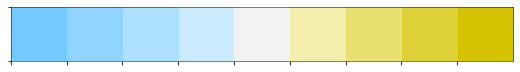

In [32]:
sns.palplot(sns.diverging_palette(235, 78, s=100, l=78, sep=2, n=9))
cmap = sns.diverging_palette(235, 78, s=100, l=78, sep=2, n=9, as_cmap=True)

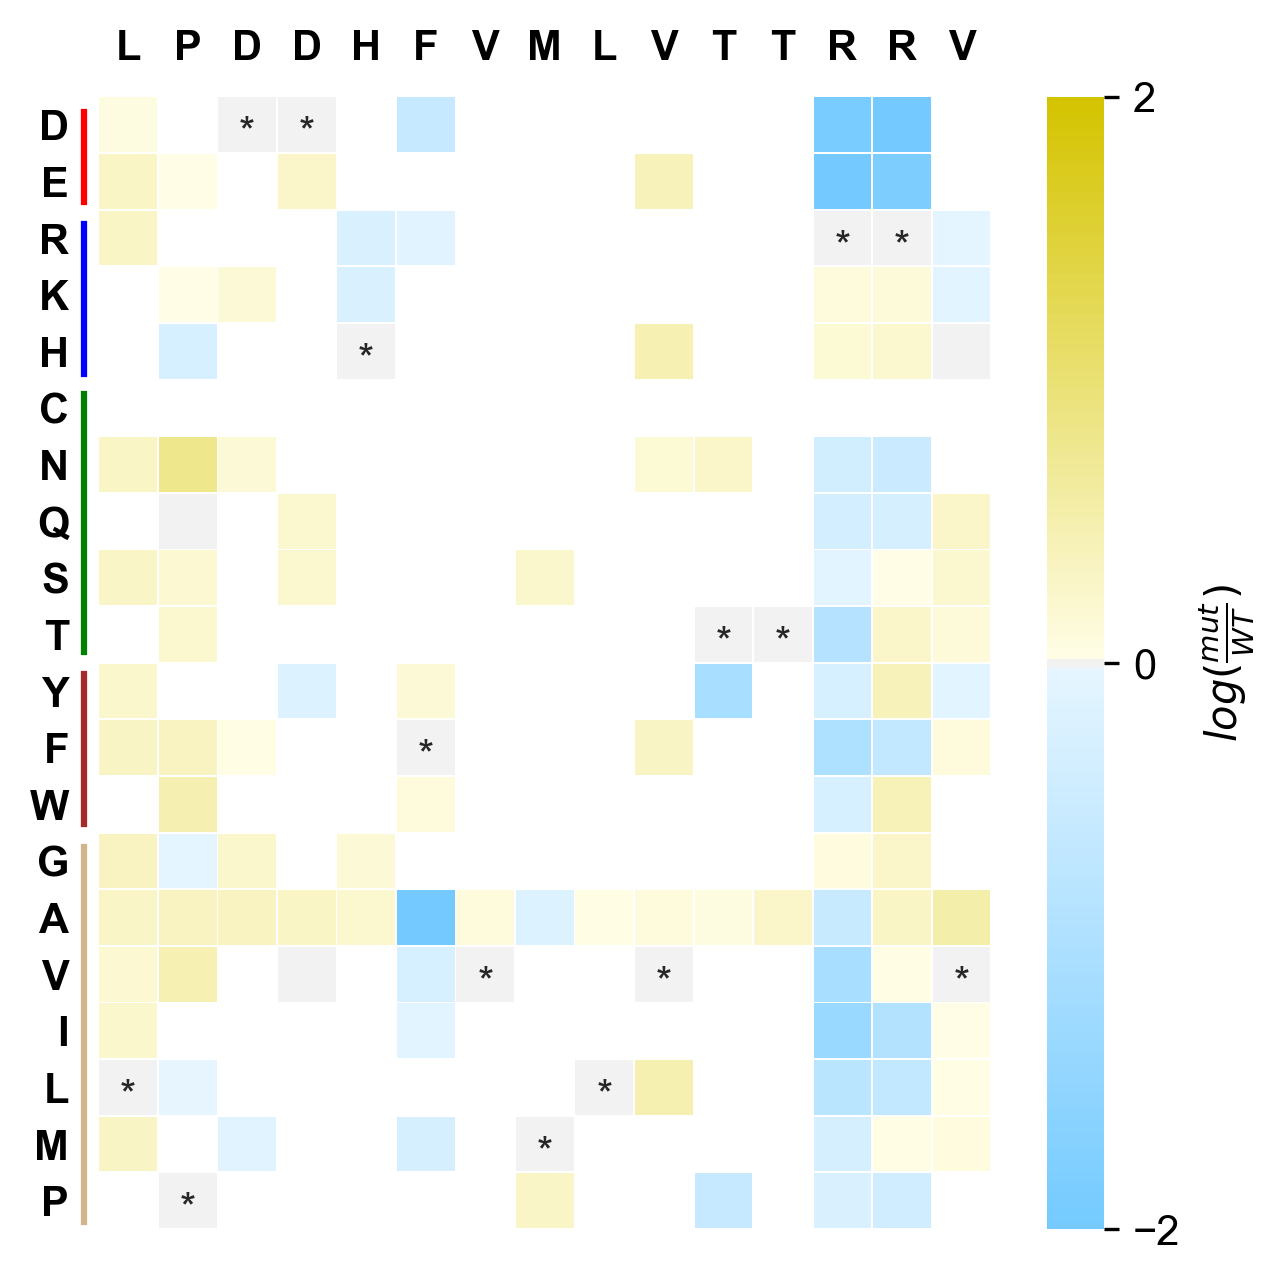

In [33]:
fig = plt.figure(figsize=(4.8,5), dpi=300)

labels = np.full((20, 15), fill_value='')
for loc in [(17,0),(19,1),(0,2),(0,3),(4,4),(11,5),(15,6),(18,7),(17,8),(15,9),(9,10),(9,11),(2,12),(2,13),(15,14)]:
    labels[loc[0], loc[1]] = '*'

fig.add_artist(lines.Line2D([0.115, 0.115], [0.87, 0.81], c='r'))
fig.add_artist(lines.Line2D([0.115, 0.115], [0.795, 0.695], c='b'))
fig.add_artist(lines.Line2D([0.115, 0.115], [0.682, 0.51], c='g'))
fig.add_artist(lines.Line2D([0.115, 0.115], [0.495, 0.395], c='brown'))
fig.add_artist(lines.Line2D([0.115, 0.115], [0.38, 0.13], c='tan'))

akws = {"va": 'bottom'}
ax = sns.heatmap(log_table, vmin=-2, vmax=2, center=0, cmap=cmap, linewidth=0.2, 
                 annot=labels, fmt='', annot_kws=akws, cbar_kws={"ticks":[-2,0,2], "label" : r'$log(\frac{mut}{WT})$'})
ax.xaxis.tick_top()
ax.set_xticklabels(ffd, fontweight='bold')
ax.set_yticklabels(AAs, rotation=0, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, 
                top = False, labeltop=True, left=False)

for t in ax.texts:
    trans = t.get_transform()
    offs = matplotlib.transforms.ScaledTranslation(0, 0.5,
                    matplotlib.transforms.IdentityTransform())
    t.set_transform( offs + trans )


# plt.savefig('Figure4D')
plt.show()